# 2.1 Compute Relative Pose
**Author:** Elliott Wobler

The folder contains the sample image and coresponding pose information.

### 1. Read the `pose.json` file.
The pose information in the JSON file contains the position (x,y,z) and quaternion (qx, qy, qz, qw).

In [17]:
import os
import json
import numpy as np
import pandas as pd
root_dir = "data/"

In [18]:
# "cam_r" = Camera’s Position in the world reference frame
# "cam_q" = Camera’s Orientation in the world reference frame
# "sat_r" = Satellite’s Position in the world reference frame
# "sat_q" = Satellite’s Orientation in the world reference frame

In [19]:
# read the json file
file_path = os.path.join(root_dir , "pose.json")
if os.path.exists(file_path):
    data = pd.read_json(file_path)
else:
    print("File not available. Please check the file path.")
# read data from pandas for the corresponding index
image_id = data.loc[0,"image_id"]
cam_r = data.loc[0,"cam_r"]
cam_q = data.loc[0,"cam_q"]
sat_r = data.loc[0,"sat_r"]
sat_q = data.loc[0,"sat_q"]

### 2. Perform frame transformation and compute the relative pose of the satellite in the Camera’s reference Frame.
Use the Computed relative pose in the Report.


In [20]:
# import utility for converting a quaternion to a rotation matrix
from scipy.spatial.transform import Rotation

In [21]:
def build_transformation_matrix(rotation, translation):
    """ Create a Transformation Matrix from rotation/translation inputs. """
    # build shortcuts for bottom row of T
    zeros = np.zeros((1,3))
    one = np.ones(1)
    # convert the Rotation class to a matrix
    R = rotation.as_matrix()
    # reshape the translation data (could also use .T to transpose)
    t = np.array([translation]).reshape(3,1)
    # build the left side of the T matrix
    T_left = np.vstack((R,zeros))
    # build the right side of the T matrix
    T_right = np.vstack((t,one))
    # combine to create the Transformation matrix  (T)
    T = np.hstack((T_left,T_right))
    return T

def get_relative_rotation_and_translation(T_cam, T_sat):
    # compute the inverse homogenous Transformation matrix
    T_cam_inv = np.linalg.inv(T_cam)
    # get the relative satellite matrix in the camera's reference frame
    T_sat_relative = np.matmul(T_cam_inv, T_sat)
    print("T_sat_relative:\n{}\n".format(T_sat_relative))
    # unpack the relative rotation and translation
    rotation_rel = T_sat_relative[0:3,0:3]
    translation_rel = T_sat_relative[0:3,3:]
    return rotation_rel, translation_rel
    
# convert quaternions to rotation matrices
sat_rotation = Rotation.from_quat(sat_q)
cam_rotation = Rotation.from_quat(cam_q)
print("sat_rotation:\n{}\n".format(sat_rotation.as_matrix()))
print("cam_rotation:\n{}\n".format(cam_rotation.as_matrix()))
# build the Transformation matrices
T_sat = build_transformation_matrix(sat_rotation, sat_r)
T_cam = build_transformation_matrix(cam_rotation, cam_r)
# get the satellite rotation and translation relative to the camera's reference frame
rotation_rel, translation_rel = get_relative_rotation_and_translation(T_cam, T_sat)
print("rotation_rel:\n{}\n".format(rotation_rel))
print("translation_rel:\n{}\n".format(translation_rel))

sat_rotation:
[[-0.22197476  0.55734455  0.80005891]
 [-0.4685698   0.65859924 -0.58880335]
 [-0.85508453 -0.50558293  0.11496241]]

cam_rotation:
[[ 0.01856728  0.01368048 -0.99973401]
 [ 0.99980037 -0.00763577  0.01846403]
 [-0.00738114 -0.99987726 -0.01381952]]

T_sat_relative:
[[-0.46628623  0.67254792 -0.57467944 -0.39053845]
 [ 0.85552075  0.5081167  -0.09950715  0.14498454]
 [ 0.2250809  -0.53804899 -0.81230651  1.15053725]
 [ 0.          0.          0.          1.        ]]

rotation_rel:
[[-0.46628623  0.67254792 -0.57467944]
 [ 0.85552075  0.5081167  -0.09950715]
 [ 0.2250809  -0.53804899 -0.81230651]]

translation_rel:
[[-0.39053845]
 [ 0.14498454]
 [ 1.15053725]]



# 2.2 Camera Projection

### 1. Read the camera.json for the intrinsic parameters necessary to construct the camera calibration matrix.

In [6]:
# nu = number of horizontal[pixels]
# nv = number of vertical[pixels]
# ppx = horizontal pixel pitch[m / pixel]
# ppy = vertical pixel pitch[m / pixel]
# fx = focal length[m]
# fy = focal length[m]
# ccx = center along horizontal [pixels]
# ccy = center along vertical[pixels] 

In [7]:
class CameraClass:
    """Utility class for accessing camera parameters."""
    def __init__(self):
        # read the json file
        file_path = os.path.join(root_dir , "camera.json")
        if os.path.exists(file_path):
            camdata = pd.read_json(file_path)
        else:
            print("File not available. Please check the file path.")
        # read data from pandas for the corresponding index
        img_width = camdata.loc[0,"Nu"]
        img_height = camdata.loc[0,"Nv"]
        # center points
        ccx = camdata.loc[0,"ccx"]
        ccy = camdata.loc[0,"ccy"]
        # pixel pitch
        ppx = camdata.loc[0,"ppx"]
        ppy = camdata.loc[0,"ppy"]
        # focal length (in meters)
        fx_m = camdata.loc[0,"fx"]
        fy_m = camdata.loc[0,"fy"]
        #################################
        #### F(mm) = F(pixels) * SensorWidth(mm) / ImageWidth (pixel)
        #### PixelPitch * HorizontalPixelCount = CameraSensorWidth
        # sensor_width = img_width * ppx
        # sensor_height = img_height * ppy
        #################################
        # calculate the focal length in pixels
        fx_pix = fx_m / ppx
        fy_pix = fy_m / ppy
        # build the camera's intrinsic matrix
        k = [
            [fx_pix, 0, ccx],
            [0, fy_pix, ccy],
            [0, 0, 1],
        ]
        # store matrix as self.K for easy access
        self.K = np.array(k)

In [8]:
# initialize the Camera class and access the intrinsic matrix (K)
Camera = CameraClass()
print(Camera.K)

[[1.39116894e+03 0.00000000e+00 9.65792100e+02]
 [0.00000000e+00 1.39195563e+03 5.54381000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### 2. Project the pose information calculated from 2.1 on the given image and verify if the pose is correct.
#### For the report:
* plot an image overlaying the satellite’s coordinate axes in RGB on the given image
* print pose information the bottom right corner of the image.

In [9]:
# import cv2 to read the image file and matplotlib for visualization
import cv2
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

In [10]:
# `project` and `visualize` code adapted from
# the Spark challenge visualization utility

def add_textbox(ax, q, r):
    """ Add textbox to the bottom right of the image. """
    # set the 
    box_text = "Pose:\nr: {}\nq: {}".format(r, q)
    # build the text box
    text_box = AnchoredText(
        box_text,
        frameon=True,
        loc=4,
        pad=0.5,
    )
    plt.setp(text_box.patch, facecolor='white', alpha=0.7)
    ax.add_artist(text_box)

def project(q, r):
    """Project points to image frame to draw axes """
    # reference points in satellite frame for drawing axes
    p_axes = np.array([
        [0, 0, 0, 1],
        [1, 0, 0, 1],
        [0, 1, 0, 1],
        [0, 0, 1, 1]
    ])
    points_body = np.transpose(p_axes)
    # transformation to camera frame
    pose_mat = np.hstack((Rotation.from_quat(q).as_matrix(), np.expand_dims(r, 1)))
    p_cam = np.dot(pose_mat, points_body)
    # getting homogeneous coordinates
    points_camera_frame = p_cam / p_cam[2]
    # projection to image plane
    points_image_plane = Camera.K.dot(points_camera_frame)
    x, y = (points_image_plane[0], points_image_plane[1])
    return x, y

def visualize_pose(img, q, r):
    """ Visualize image, with ground truth pose axes projected to training image. """
    fig, ax = plt.subplots()
    ax.imshow(img)
    # perform the projection
    xa, ya = project(q, r)
    # scale of visualized axes
    scale = 500
    # set vector endpoints
    c = np.array([[xa[0]], [ya[0]]])
    p = np.array([[xa[1], xa[2], xa[3]], [ya[1], ya[2], ya[3]]])
    # print('center:', c)
    # set vector length
    v = p - c
    # apply scalar to vector length
    v = scale * v / np.linalg.norm(v)
    # draw the axis arrows with red, green, and blue colors
    ax.arrow(c[0, 0], c[1, 0], v[0, 0], v[1, 0], head_width=20, color="r")
    ax.arrow(c[0, 0], c[1, 0], v[0, 1], v[1, 1], head_width=20, color="g")
    ax.arrow(c[0, 0], c[1, 0], v[0, 2], v[1, 2], head_width=20, color="b")
    # add the text box with pose data in the bottom right
    add_textbox(ax, q, r)
    return

In [11]:
# read the satellite image and convert to desired colorspace
img_path = os.path.join(root_dir , image_id)
im_read = cv2.imread(img_path)
image = cv2.cvtColor(im_read, cv2.COLOR_BGR2RGB)

r_rel: [-0.39053845  0.14498454  1.15053725]
q_rel:
[ 0.45768537  0.83467201 -0.19096008 -0.2395433 ]



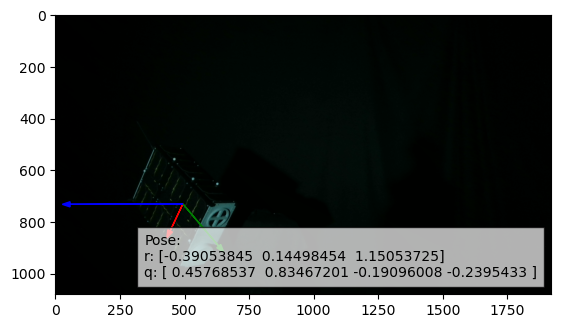

In [12]:
# convert the new relative rotation and translation
# back to the original quaternion and position format
q_rel = Rotation.from_matrix(rotation_rel).as_quat()
r_rel = translation_rel.flatten()
print('r_rel:', r_rel)
print('q_rel:\n{}\n'.format(q_rel))
# visualize the image and pose axes
visualize_pose(image, q_rel, r_rel)
plt.show()

# 2.3 Project Keypoints

### 1. Read the `points3d.txt` files for the position of the keypoints in the satellite own reference frame.
The keypoint location are in the format (x,y,z).

In [13]:
# read the text file
file_path = os.path.join(root_dir , "points3d.txt")
if os.path.exists(file_path):
    points_sat_ref = df = pd.read_csv(file_path, names=["x","y","z"])
else:
    print("File not available. Please check the file path.")
    
# check the data
print(points_sat_ref.loc[0])
points_sat_ref

x    0.1136
y   -0.1700
z   -0.0500
Name: 0, dtype: float64


,x,y,z
0,0.1136,-0.17,-0.05
1,-0.1136,-0.17,-0.05
2,-0.1136,-0.17,0.05
3,0.1136,-0.17,0.05
4,0.1136,0.17,-0.05
5,-0.1136,0.17,-0.05
6,-0.1136,0.17,0.05
7,0.1136,0.17,0.05


### 2. Find the position of the keypoints relative to the camera using the pose information calculated from 2.1.
#### Print the locations of the keypoints in the Camera’s Reference Frame.

In [14]:
# pose information calculated from 2.1
Rt = np.hstack((rotation_rel,translation_rel))
# output array to store projected coordinates
projected_keypoints = []
# iterate through keypoint locations
# and project each one, storing in output array
# using the equation from Slide 33 of Lecture 7
num_points = points_sat_ref.shape[0]
for i in range(0, num_points):
    # get coordinate
    xyz = points_sat_ref.loc[i]
    # convert to column vector
    xyz = np.array([xyz]).T
    # add constant of 1 to bottom of column vector
    xyz1 = np.vstack((xyz,[1]))
    # multiply matrix terms
    term = np.matmul(Rt, xyz1)
    uvN = np.matmul(Camera.K, term)
    # find scalar value 
    s = 1.0 / uvN[2]
    # scale vector to make third term = 1
    uv1 = s * uvN
    # append projected point to output array
    projected_keypoints.append(uv1)
###############################
projected_keypoints

[array([[403.12291606],
        [725.44239845],
        [  1.        ]]),
 array([[497.47604992],
        [517.16726132],
        [  1.        ]]),
 array([[397.129798  ],
        [502.81656627],
        [  1.        ]]),
 array([[300.71235645],
        [725.4786471 ],
        [  1.        ]]),
 array([[594.35150293],
        [966.95884262],
        [  1.        ]]),
 array([[713.87863175],
        [734.71011193],
        [  1.        ]]),
 array([[612.74831558],
        [735.51312388],
        [  1.        ]]),
 array([[488.8748965 ],
        [985.79273598],
        [  1.        ]])]

### 3. Project the estimated 3D position of the keypoints onto image using the information and compute the 2D coordinates of the image keypoints.
#### Plot the image with identified keypoint locations.

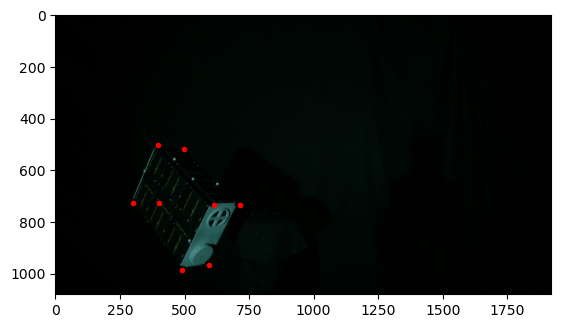

In [16]:
def visualize_keypoints(img, keypoints):
    """ Visualize image, with keypoints projected onto original image. """
    fig, ax = plt.subplots()
    ax.imshow(img)
    # draw the keypoints
    for k in keypoints:
        x = k[0]
        y = k[1]
        ax.plot([x], [y], marker='o', markersize=3, color="red")
    return

# visualize the image and keypoints
visualize_keypoints(image, projected_keypoints)
plt.show()